# [Assistants migration guide](https://platform.openai.com/docs/assistants/migration)

# Constants and Libraries

In [1]:
import os
from dotenv import load_dotenv # requires python-dotenv

if not load_dotenv("./../../config/credentials_my.env"):
    print("Environment variables not loaded, cell execution stopped")
    sys.exit()
print("Environment variables have been loaded ;-)")

QUESTION = "Create a visualization of a sinewave"

Environment variables have been loaded ;-)


# Create a client to connecto Azure OpenAI service and deployment

In [2]:
from openai import AzureOpenAI

# Create the client
client = AzureOpenAI(
    # api_key        = os.getenv("AZURE_OPENAI_API_KEY"),  
    # api_version    = os.getenv("AZURE_OPENAI_API_VERSION"), # at least 2024-02-15-preview
    # azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
)
print(f"client.base_url: {client.base_url}")

client.base_url: https://mmoaiswc-01.openai.azure.com/openai/


# Create an Assistant with `code_interpreter`

In [3]:
assistant = client.beta.assistants.create(
    name="Smart Assistant",
    description="You are a helpful AI assistant who helps answering questions",
    tools = [{"type": "code_interpreter"}],
    model = "gpt-4o" # gpt-4.1 still not supported by Assistants API's
)

assistant

Assistant(id='asst_QQrz6xKTf2pFTMf3CTBkStrl', created_at=1745505281, description='You are a helpful AI assistant who helps answering questions', instructions=None, metadata={}, model='gpt-4o', name='Smart Assistant', object='assistant', tools=[CodeInterpreterTool(type='code_interpreter')], response_format='auto', temperature=1.0, tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=[]), file_search=None), top_p=1.0)

# Create a conversation
Note that `code_interpreter` and `file_search` are empty in this case, because `code_interpreter` was not created.

In [4]:
# Create a thread
thread = client.beta.threads.create()
print(thread)

Thread(id='thread_MVkpIpDbf2IXiWAAMTziKjnk', created_at=1745505282, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=None, file_search=None))


# Add a message to the conversation

In [5]:
# Add a user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content=QUESTION
)

thread_messages = client.beta.threads.messages.list(thread.id)

print(thread_messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_JnDPmIfydsZ7Ds8drsHBMQR8",
      "assistant_id": null,
      "attachments": [],
      "completed_at": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "Create a visualization of a sinewave"
          },
          "type": "text"
        }
      ],
      "created_at": 1745505282,
      "incomplete_at": null,
      "incomplete_details": null,
      "metadata": {},
      "object": "thread.message",
      "role": "user",
      "run_id": null,
      "status": null,
      "thread_id": "thread_MVkpIpDbf2IXiWAAMTziKjnk"
    }
  ],
  "has_more": false,
  "object": "list",
  "first_id": "msg_JnDPmIfydsZ7Ds8drsHBMQR8",
  "last_id": "msg_JnDPmIfydsZ7Ds8drsHBMQR8"
}


# Create a Run and check its status

In [6]:
import time, json

run            = client.beta.threads.runs.create(
  thread_id    = thread.id,
  assistant_id = assistant.id,
)

while client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id).status in ["queued", "in_progress"]:
    print(f"Run status: {run.status}")
    time.sleep(5)

print(f"Final run status: {client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id).status}")

json.loads(client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id).to_json())

Run status: queued
Run status: queued
Final run status: completed


{'id': 'run_eGD1sS9DPSXX17ccLBYGgE4g',
 'assistant_id': 'asst_QQrz6xKTf2pFTMf3CTBkStrl',
 'cancelled_at': None,
 'completed_at': 1745505289,
 'created_at': 1745505282,
 'expires_at': None,
 'failed_at': None,
 'incomplete_details': None,
 'instructions': None,
 'last_error': None,
 'max_completion_tokens': None,
 'max_prompt_tokens': None,
 'metadata': {},
 'model': 'gpt-4o',
 'object': 'thread.run',
 'parallel_tool_calls': True,
 'required_action': None,
 'response_format': 'auto',
 'started_at': 1745505283,
 'status': 'completed',
 'thread_id': 'thread_MVkpIpDbf2IXiWAAMTziKjnk',
 'tool_choice': 'auto',
 'tools': [{'type': 'code_interpreter'}],
 'truncation_strategy': {'type': 'auto', 'last_messages': None},
 'usage': {'completion_tokens': 145,
  'prompt_tokens': 390,
  'total_tokens': 535,
  'prompt_token_details': {'cached_tokens': 0}},
 'temperature': 1.0,
 'top_p': 1.0,
 'tool_resources': {}}

# Extract the final result from the run
## Run the next cells **ONLY IF** `run.status = completed`

In [7]:
messages = client.beta.threads.messages.list(thread_id=thread.id)

file_id = ""

for c in json.loads(messages.to_json())["data"][0]["content"]:
    if c["type"]=="text":
        print(f'text: {c["text"]["value"]}')
    elif c["type"]=="image_file":
        file_id = c["image_file"]["file_id"]
        print(f'image_file: {file_id}')

image_file: assistant-GDT5vSJnRSaRg4szA2o7vi
text: Here is a visualization of a sine wave. The x-axis represents the angle in radians from 0 to \(2\pi\), and the y-axis represents the sine of the angle. The wave patterns are smooth and periodic, characteristic of sine functions.


# Save and Visualize the .png file

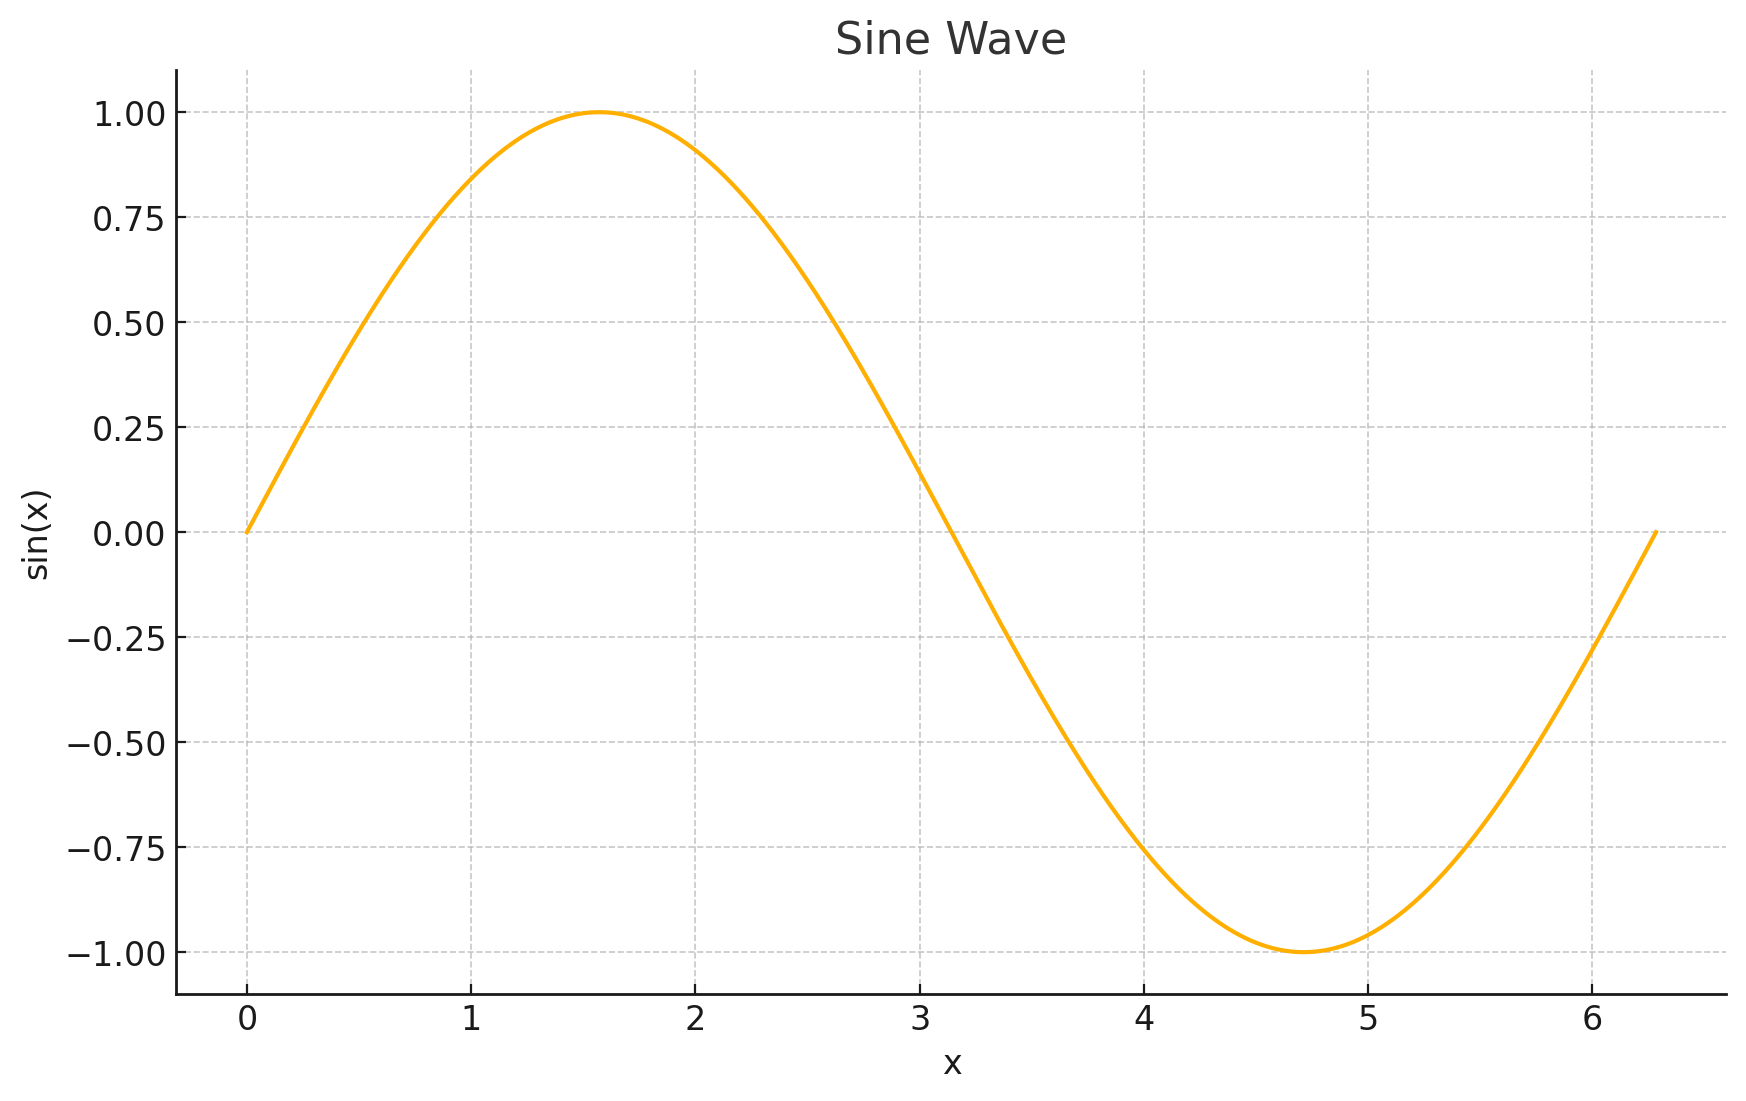

In [8]:
# Use the file id to retrieve the file content and save it on disk

from IPython.display import Image, display

content = client.files.content(file_id=file_id)
image= content.write_to_file(f"{file_id}.png")

# Display the image in the default image viewer
display(Image(filename=f"{file_id}.png")) 

# Add a new user question to the thread message list

In [9]:
client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Show me the code you used to generate the sinewave"
)

messages = client.beta.threads.messages.list(thread_id=thread.id)

In [10]:
for m in messages:
    print(m.content, '\n')

[TextContentBlock(text=Text(annotations=[], value='Show me the code you used to generate the sinewave'), type='text')] 

[ImageFileContentBlock(image_file=ImageFile(file_id='assistant-GDT5vSJnRSaRg4szA2o7vi', detail=None), type='image_file'), TextContentBlock(text=Text(annotations=[], value='Here is a visualization of a sine wave. The x-axis represents the angle in radians from 0 to \\(2\\pi\\), and the y-axis represents the sine of the angle. The wave patterns are smooth and periodic, characteristic of sine functions.'), type='text')] 

[TextContentBlock(text=Text(annotations=[], value='Create a visualization of a sinewave'), type='text')] 



# Print the result of the second question

In [11]:
import time, json

run            = client.beta.threads.runs.create(
  thread_id    = thread.id,
  assistant_id = assistant.id,
  #instructions="New instructions" #You can optionally provide new instructions but these will override the default instructions
)

while client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id).status in ["queued", "in_progress"]:
    print(f"Run status: {run.status}")
    time.sleep(5)

print(f"Final run status: {client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id).status}")

Run status: queued
Final run status: completed


In [12]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import TerminalFormatter

print(highlight(
    client.beta.threads.messages.list(thread_id=thread.id).data[0].content[0].text.value,
    PythonLexer(), TerminalFormatter()))

Certainly! Here is the code used to generate and visualize the sine wave:

```python
import numpy as np
import matplotlib.pyplot as plt

# Generate data for sine wave
x = np.linspace(0, 2 * np.pi, 1000)
y = np.sin(x)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title("Sine Wave")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.grid(True)
plt.show()
```

### Explanation:
- **Data Generation**:
  - `x = np.linspace(0, 2 * np.pi, 1000)`: This line creates 1000 evenly spaced values between 0 and \(2\pi\).
  - `y = np.sin(x)`: This calculates the sine of each value in `x`.

- **Plotting**:
  - `plt.figure(figsize=(10, 6))`: This sets the dimensions of the figure.
  - `plt.plot(x, y)`: This plots the sine wave using the values from `x` and `y`.
  - `plt.title("Sine Wave")`: This adds a title to the plot.
  - `plt.xlabel("x")` and `plt.ylabel("sin(x)")`: These label the x-axis and y-axis respectively.
  - `plt.grid(True)`: This adds a grid for easier visualization.
  - `plt.show

## START teardown for the current assistant

In [13]:
for message in client.beta.threads.messages.list(thread.id):
    print (f"Deleting message id = <{message.id}>... of thread <{thread.id}>...")
    client.beta.threads.messages.delete(message_id=message.id, thread_id=thread.id)

print(f"\nDeleting thread {thread.id}...")
client.beta.threads.delete(thread_id=thread.id)

print(f"\nDeleting assistant {assistant.id} ({assistant.name})...")
client.beta.assistants.delete(assistant.id)

Deleting message id = <msg_VSBHzu8i9T56elW1A6hmrFl7>... of thread <thread_MVkpIpDbf2IXiWAAMTziKjnk>...
Deleting message id = <msg_436QEoKmHSVJbHkfowRe56sh>... of thread <thread_MVkpIpDbf2IXiWAAMTziKjnk>...
Deleting message id = <msg_vn5zbbryfo6Lfc9eAP6HKAXj>... of thread <thread_MVkpIpDbf2IXiWAAMTziKjnk>...
Deleting message id = <msg_JnDPmIfydsZ7Ds8drsHBMQR8>... of thread <thread_MVkpIpDbf2IXiWAAMTziKjnk>...

Deleting thread thread_MVkpIpDbf2IXiWAAMTziKjnk...

Deleting assistant asst_QQrz6xKTf2pFTMf3CTBkStrl (Smart Assistant)...


AssistantDeleted(id='asst_QQrz6xKTf2pFTMf3CTBkStrl', deleted=True, object='assistant.deleted')

# New question: now we want the picture using dark mode
## Now we run everything in a single cell

Run status: queued
Final run status: completed
image_file: assistant-1XkodviFJep8ELnWptvS38
text: Here is a visualization of a sine wave. The graph shows `sin(x)` over the interval from \(0\) to \(2\pi\). The vertical lines indicate the positions of \(\pi\) and \(2\pi\) for reference.


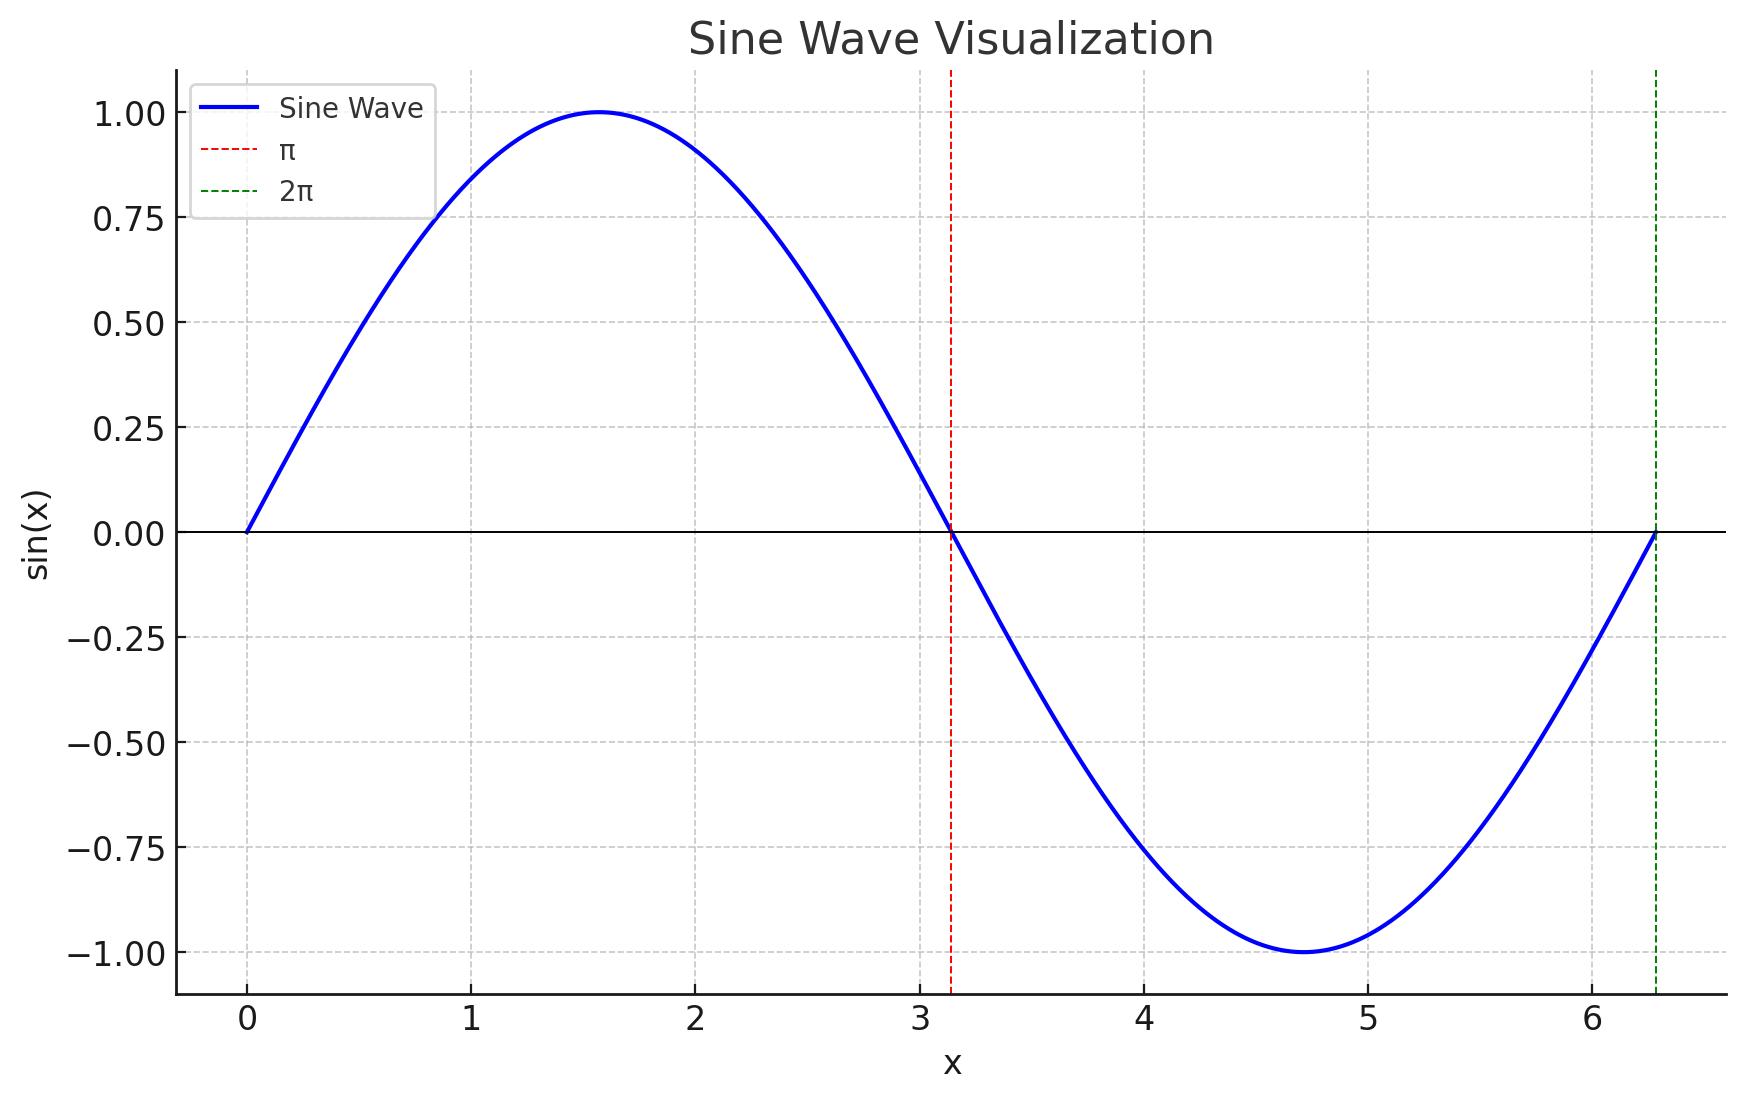

In [14]:
# Create the client
client = AzureOpenAI(
    azure_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"],
    api_key        = os.environ["AZURE_OPENAI_API_KEY"],
    api_version    = os.environ["OPENAI_API_VERSION"],
)

# Create the assistant
assistant = client.beta.assistants.create(
    name="Smart Assistant",
    description="You are a helpful AI assistant who helps answering questions",
    tools = [{"type": "code_interpreter"}],
    model = "gpt-4o", # gpt-4.1 still not supported by Assistants API's
)

# Create a thread
thread = client.beta.threads.create()

# Add a user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content=QUESTION
)

run            = client.beta.threads.runs.create(
  thread_id    = thread.id,
  assistant_id = assistant.id,
  #instructions="New instructions" #You can optionally provide new instructions but these will override the default instructions
)

# Invoke the LLM passing the thread messages list
while client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id).status in ["queued", "in_progress"]:
    print(f"Run status: {run.status}")
    time.sleep(5)

print(f"Final run status: {client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id).status}")
 
messages = client.beta.threads.messages.list(thread_id=thread.id)

file_id = ""

for c in json.loads(messages.to_json())["data"][0]["content"]:
    if c["type"]=="text":
        print(f'text: {c["text"]["value"]}')
    elif c["type"]=="image_file":
        file_id = c["image_file"]["file_id"]
        print(f'image_file: {file_id}')

content = client.files.content(file_id=file_id)
image= content.write_to_file(f"{file_id}.png")

# Display the image in the default image viewer
display(Image(filename=f"{file_id}.png")) 

# Teardown for *all** assistants and messages [(but **NOT** threads!)](https://learn.microsoft.com/en-us/answers/questions/2153170/assistants-api-where-and-how-long-are-entities-sav)
When creating a new thread with the Assistants API, thereby creating a stateful entity of: Threads, messages, where is this data stored, can I access the resource that stores these? Or is the resource managed entirely by Microsoft, and inaccessible to me?
When you create a new thread with the Assistants API, the data (threads, messages, etc.) is stored in a secure, Microsoft-managed storage account. This storage is logically separated to ensure data security. As a user, you do not have direct access to the underlying storage resources. Instead, you interact with the data through the API endpoints provided by Microsoft.

If a thread with messages is created via the API, and the ID is lost, is there then no route to access and delete this thread? As in, would there be a way to somehow fetch all threads related to a specific OpenAI Azure resource?
If you lose the thread ID, there is no direct way to retrieve or delete the thread through the API. The Assistants API does not currently provide a method to list all threads associated with a specific OpenAI Azure resource. Therefore, it's crucial to manage and store thread IDs securely within your application to ensure you can access and manage them as needed.

Is stateful entities stored INDEFINITELY unless deleted? Or is the a time to live if not used?
All used data persists in this system unless you explicitly delete this data. Use the delete function with the thread ID of the thread you want to delete. Clearing the Run in the Assistants Playground does not delete threads, however deleting them using delete function will not list them in the thread page.

In [15]:
from datetime import datetime

assistants = client.beta.assistants.list(limit=100).data
i=0
while len(assistants) > 0:
    for assistant in assistants: 
        i=i+1
        print(f"Deleting assistant {i}: {assistant.id} ({assistant.name}) created at {datetime.fromtimestamp(assistant.created_at).strftime('%Y-%m-%d %H:%M:%S')}...")
        client.beta.assistants.delete(assistant.id)
    assistants = client.beta.assistants.list(limit=100).data

print (f"\n{i} assistants have been successfully deleted.")

Deleting assistant 1: asst_ic30ohrxx7DySMZ3PiPt73JE (Smart Assistant) created at 2025-04-24 16:35:04...
Deleting assistant 2: asst_n4DkdPOzOvceZR93qiuttkMr (Smart Assistant) created at 2025-04-24 16:34:51...

2 assistants have been successfully deleted.
